## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [44]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [45]:
df = pd.read_csv("ab_data.csv")

b. Use the cell below to find the number of rows in the dataset.

In [46]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [47]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


c. The number of unique users in the dataset.

In [48]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [49]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [50]:
NewPage_And_Treatment_NotMatching =df.query('landing_page == "new_page" & group == "control"').shape[0] + df.query('landing_page == "old_page" & group == "treatment"').shape[0]
NewPage_And_Treatment_NotMatching

3893

f. Do any of the rows have missing values?

In [51]:
df.isnull().sum().any()

False

From the answer above We get that there are no Missing values!

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [52]:
#filter the dstaframe to get the correct allignment.
df2 = df.query('landing_page == "new_page"&group == "treatment"')
df2 = df2.append(df.query('landing_page== "old_page" & group =="control"'))

In [53]:
#Checking if all of the correct rows were removed
#Note: the answer should be zero
df2[((df2['group']== 'treatment') ==(df2['landing_page']== 'new_page'))==False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [54]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [55]:
df2['user_id'][(df2['user_id'].duplicated()==True)]

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [56]:
#duplicate user index
df2.loc[2893]


user_id                             773192
timestamp       2017-01-14 02:55:59.590927
group                            treatment
landing_page                      new_page
converted                                0
Name: 2893, dtype: object

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [57]:
df2.drop([3442], inplace=True)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [58]:
#conversions, 1s is True and 0s is False
np.mean(df['converted'])

0.11965919355605512

b. Given that an individual was in the `control` group, what is the probability they converted?

In [59]:
#Converted probability of control

np.mean(df.query('group=="control"')['converted'])


0.12039917935897611

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [60]:
#Converted probability of treatment
np.mean(df.query('group =="treatment"')['converted'])



0.11891957956489856

d. What is the probability that an individual received the new page?

In [61]:
#new_pages probability in the dataset
df.query('landing_page =="new_page"').shape[0]/df.shape[0]


0.5

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

In [62]:
(df2.query('group == "control" & converted == 1').shape[0]/ df2.query('group == "control"').shape[0])\
-df2.query('group == "treatment" & converted == 1').shape[0]/ df2.query('group == "treatment"').shape[0]

0.0015798852878394776

**Based on the resulat of .15 we conclude that we are not sure that the new treatment page leads to more conversions**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [63]:
Pnew =df2.converted.mean()
Pnew


0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [64]:
Pold =df2.converted.mean()
Pold


0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [65]:
Nnew =df2.query('landing_page=="new_page"').count()[0]
Nnew

145311

d. What is $n_{old}$, the number of individuals in the control group?

In [66]:
Nold =df.query('landing_page=="old_page"').count()[0]
Nold

147239

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [67]:
new_page_converted =np.random.binomial(1,Pnew,Nnew)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [68]:

old_page_converted =np.random.binomial(1,Pold, Nold)


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [69]:
print(new_page_converted.mean()-old_page_converted.mean())


-0.002158769921868642


h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [70]:
#Create New Array
p_diffs = []
#Assaign new_converted varible
new_convert = np.random.binomial(Nnew,Pnew,10000)/Nnew

#Assaign new_converted varible
old_convert = np.random.binomial(Nold,Pold,10000)/Nold

#Calculating the difference
p_diffs = new_convert-old_convert

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

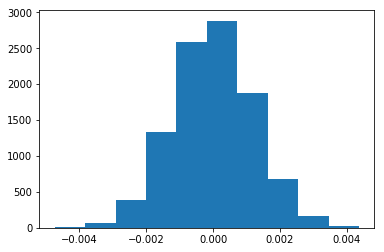

In [71]:
plt.hist(p_diffs)
plt.show()

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [72]:
ad = df[df['group'] == 'treatment']['converted'].mean()-df[df['group']== 'control']['converted'].mean()
ad

-0.0014795997940775518

In [73]:
p_diffs= np.array(p_diffs)
(p_diffs> ad).mean()


0.8914

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**because the p-value=0.89 so we can assume the null hypothesis is true because the p-value is not less than 0.05 we can't 
**reject the null hypothesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [74]:
import statsmodels.api as sm

convert_old = df2.query('landing_page=="old_page" and converted==1').count()[0]
convert_new = df2.query('landing_page=="new_page" and converted==1').count()[0]
n_old = df2.query('landing_page=="old_page"').count()[0]
n_new = df2.query('landing_page=="new_page"').count()[0]

print ('convert old=', convert_old , ',    N old= ',n_old ,'  ----   convert new=' ,convert_new ,'   N New=', n_new)

convert old= 17489 ,    N old=  145273   ----   convert new= 17264    N New= 145311


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [75]:
z_score, p_value =sm.stats.proportions_ztest(count = [convert_new,convert_old],nobs = [n_new,n_old],alternative ='larger')


In [76]:
print ("z score=",z_score)

z score= -1.3122916566912053


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The P-Value can be described as the probability that the data is due to chance. If the Z-score is above the critical value we can reject the null hypothesis and accept the alternative hypothesis in these parts, we can't reject the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [77]:
df2['intercept'] = 1
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [78]:
import statsmodels.api as sm

logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [79]:
results.summary2()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3466
Date:               2020-06-26 16:56 BIC:              212801.5059
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18942    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6679  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3123  0.1894  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p value associated with ab_page= 0.1894**

**The values  differ from the value you found in Part II because in part II we sampled the data randomly**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Adding more variables to the regression modell is usefull but it can cause conflict between the varibles.
 also, the complexity of the model can be seen as a disadvantage.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [80]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head(10)

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page
user_id,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0
630005,US,2017-01-17 21:22:25.940766,treatment,new_page,1,1,1,0
630006,US,2017-01-14 05:13:51.962356,treatment,new_page,0,1,1,0
630008,US,2017-01-11 16:11:11.131461,control,old_page,0,1,0,1
630009,US,2017-01-05 23:35:15.820565,control,old_page,1,1,0,1


In [81]:
df_new[['US','CA','UK']] = pd.get_dummies(df_new['country'])


In [82]:
df_new['intercept'] = 1
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept','UK', 'CA']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2020-06-26 16:56 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
UK             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
CA             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
==================================================================

"""

**We should accept null hypothisis because p-value above are all greater than the critical value.
Even with adding country as a factor, it doesn't change the result as shown above.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [83]:
df_new['US_ab_page']= df_new['US'] * df_new['ab_page']
df_new['UK_ab_page']= df_new['UK']* df_new['ab_page']
df_new.head(10)

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,US,CA,UK,US_ab_page,UK_ab_page
user_id,,,,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,0,0,1,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,0,0,1,0,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1,0,0,1,0,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0,0,0,1,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0,0,0,1,0,1
630005,US,2017-01-17 21:22:25.940766,treatment,new_page,1,1,1,0,0,0,1,0,1
630006,US,2017-01-14 05:13:51.962356,treatment,new_page,0,1,1,0,0,0,1,0,1
630008,US,2017-01-11 16:11:11.131461,control,old_page,0,1,0,1,0,0,1,0,0
630009,US,2017-01-05 23:35:15.820565,control,old_page,1,1,0,1,0,0,1,0,0


In [84]:
log_mod_int = sm.Logit(df_new['converted'],df_new[['intercept','US','UK','ab_page','US_ab_page','UK_ab_page']])
results_int = log_mod_int.fit()
results_int.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6553
Date:               2020-06-26 16:56 BIC:              212846.1332
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19166    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9922    0.0161  -123.4571  0.0000  -2.0238  -1.9606
US           -0.0118    0.0398    -0.2957  0.7674  -0.0899   0.0663
UK            0.0058    0.0188     0.3063  0.7594  -0.0311   0.0426
ab_page       0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
US_ab_page   -0.0783    0.0568    -1.3783  0.1681  -0.1896   0.0330
UK_ab_page   -0.0314    0.0266    -1.1816  0.2374  -0.0835   0.0207
==================================================================

"""

**We notice that the p-values are greater than the critical value in all of the above.
Based on that we can say that there is no considrable effects on converting between different interactions between pages.**

## Conclusion:

Finally, In our analysis we tried to see if the new page will be better than the old one and because we failed to regect the null hypothesis with every method we can conclud by saying that there is no significance for converting the old page to the new page.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!




## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [85]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0